# Constants 

In [278]:
import pandas as pd # for loading xlsx files
import os
import numpy as np

In [279]:
# changing directory to 'project root dir' 
BASE_DIR = os.path.split(os.path.abspath(''))[0]
data_name = 'Dataset4'

data_add = os.path.join(BASE_DIR, 'Data' , data_name + '.xlsx')
Sheet_names= ['IS_R','OS_R','OS_P']

#print('.ls:')
#%ls

# 1) Loading data / Adding to Gams WS / Exporting gdx

In [280]:
# 1.1 loading data
i = 100
t_train = 104
t_test = 52
dum = 1
lower = 0.01
upper = 0.3
c1 = 10
c2 = 15

df_IS = pd.read_excel(io = data_add, sheet_name = Sheet_names[0],engine='openpyxl')
df_OS = pd.read_excel(io = data_add, sheet_name =Sheet_names[1],engine='openpyxl')
#df_IS.info()
#df_IS.head()
#df_IS.tail()

# choose a c
c = c1


In [281]:
# 1.2) Creating GAMS workspace and a db object from it:
import gams
ws = gams.workspace.GamsWorkspace(BASE_DIR)
opt = ws.add_options()
db = ws.add_database()
opt.defines["gdxincname"] = db.name

In [282]:
# 1.2) adding Sets and Parameters to our db:
i_set = db.add_set('i', 1)
for ip in range(1,i+1):
    i_set.add_record(str(ip))

t_set = db.add_set('t', 1)
for ip in range(1,t_train+1):
    t_set.add_record(str(ip))

dum_set = db.add_set('dum', 1)
dum_set.add_record('1')

c_param = db.add_parameter_dc('c', [dum_set])
c_param.add_record('1').value = c

lower_param = db.add_parameter_dc('lower', [i_set])
for ip in range(1,i+1):
    lower_param.add_record(str(ip)).value = lower

upper_param = db.add_parameter_dc('upper', [i_set])
for ip in range(1,i+1):
    upper_param.add_record(str(ip)).value = upper
    
ir_param = db.add_parameter_dc('ir', [t_set])
for ip in range(1,t_train+1):
    ir_param.add_record(str(ip)).value = df_IS[ip][100]

i_param = db.add_parameter_dc('r', [i_set,t_set])
for ip in range(1,i+1):
    for tp in range(1,t_train+1):
        i_param.add_record((str(ip),str(tp))).value = df_IS[tp][ip-1]


# 2) Running Model / Receiving variables results

In [283]:
# 2.1) run
model = ws.add_job_from_file("index.gms")
model.run(opt, databases = db)

In [284]:
# 2.2) Receive results
objective_function = {}
for rec in model.out_db['z']:
    objective_function.setdefault('obj', rec.level) 

In [285]:
delta = {}
for rec in model.out_db['delta']:
    delta.setdefault(rec.key(0), rec.level)

In [286]:
x = {}
for rec in model.out_db['x']:
    x.setdefault(rec.key(0), rec.level)

In [300]:
x

{'1': 0.0,
 '2': 0.0,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.009999999999999946,
 '7': 0.0,
 '8': 0.0,
 '9': 0.0,
 '10': 0.0,
 '11': 0.0,
 '12': 0.010000000000000028,
 '13': 0.0,
 '14': 0.27999999999999997,
 '15': 0.0,
 '16': 0.0,
 '17': 0.0,
 '18': 0.0,
 '19': 0.0,
 '20': 0.0,
 '21': 0.01,
 '22': 0.0,
 '23': 0.0,
 '24': 0.3,
 '25': 0.0,
 '26': 0.010000000000000009,
 '27': 0.0,
 '28': 0.0,
 '29': 0.0,
 '30': 0.0,
 '31': 0.0,
 '32': 0.01,
 '33': 0.0,
 '34': 0.0,
 '35': 0.0,
 '36': 0.009999999999999995,
 '37': 0.0,
 '38': 0.0,
 '39': 0.0,
 '40': 0.0,
 '41': 0.0,
 '42': 0.0,
 '43': 0.01,
 '44': 0.01,
 '45': 0.0,
 '46': 0.0,
 '47': 0.0,
 '48': 0.0,
 '49': 0.0,
 '50': 0.0,
 '51': 0.0,
 '52': 0.0,
 '53': 0.0,
 '54': 0.01,
 '55': 0.0,
 '56': 0.0,
 '57': 0.0,
 '58': 0.0,
 '59': 0.0,
 '60': 0.01,
 '61': 0.0,
 '62': 0.0,
 '63': 0.0,
 '64': 0.0,
 '65': 0.0,
 '66': 0.0,
 '67': 0.0,
 '68': 0.0,
 '69': 0.0,
 '70': 0.0,
 '71': 0.0,
 '72': 0.0,
 '73': 0.009999999999999969,
 '74': 0.3,
 '75': 0.0,
 '

# 3) read assets return and calculate price of portfolio and index

In [287]:
import numpy as np
assets_number = 100

In [288]:
test_assets_return = np.zeros((assets_number,t_test))

for t in range(t_test):
    for n in range(assets_number):
        test_assets_return[n][t] = float(df_OS[t + 1][n + 1])


In [289]:
# calculate price of portfolio
portfolio_price = np.zeros(t_test + 1)

for t in range(1,(t_test + 1)):
    value = 0
    for nb in range(1,assets_number + 1):
        val = 1
        for t_prime in range(1,t+1):
            val *= ( 1 + test_assets_return[nb-1][t_prime-1])
        value += x[str(nb)] * val
    
    portfolio_price [t] =  value     

In [290]:
test_index_return = np.zeros(t_test )

for t in range(t_test):
    test_index_return[t] = float(df_OS[t+1][100])

In [291]:
#calculate index return of portfolio
test_index_price = np.zeros(t_test + 1)

for t in range(1,(t_test + 1)):
    value = 1 
    for t_prime in range(1,t+1):
        value *= ( 1 + test_index_return[t_prime-1])
    test_index_price [t] =  value

# 4) Visualizing the price of index and portfolio

In [292]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as figure
import pandas as pd

In [293]:
index_and_portfolio_price = np.stack([test_index_price[1:], portfolio_price[1:]], axis = 0)
index_and_portfolio_price = index_and_portfolio_price.T

<Figure size 432x288 with 0 Axes>

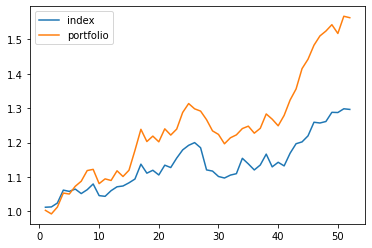

In [294]:
index_and_portfolio_price_df = pd.DataFrame(index_and_portfolio_price, index = range(1,t_test + 1), columns = ["index","portfolio"])

plt.figure(); index_and_portfolio_price_df.plot(); plt.legend(loc='best')
plt.savefig(os.path.join(BASE_DIR,'price_result', str(c2) + '_' + data_name + '.png'))

# 5) calculate total return of portfolio and index

In [295]:
portfolio_return = np.zeros(t_test + 1)

for t in range(1,(t_test + 1)):
    value = 0
    for nb in range(1,assets_number + 1):
        value += x[str(nb)] * test_assets_return[nb-1][t-1]
    portfolio_return [t] =  value    

In [296]:
portfolio_total_return = np.ones(t_test + 1)

for t in range(1,(t_test + 1)): 
    portfolio_total_return [t] =  ( 1 + portfolio_return[t]) * portfolio_total_return [t-1]

In [297]:
index_total_return = np.zeros(t_test + 1)

for t in range(1,(t_test + 1)):
    value = 1 
    for t_prime in range(1,t+1):
        value *= ( 1 + test_index_return[t_prime-1])
    index_total_return [t] =  value

# 7)visualysing total return of portfolio and index

In [298]:
index_and_portfolio_total_return = np.stack([index_total_return[1:], portfolio_total_return[1:]], axis = 0)
index_and_portfolio_total_return = index_and_portfolio_total_return.T

<Figure size 432x288 with 0 Axes>

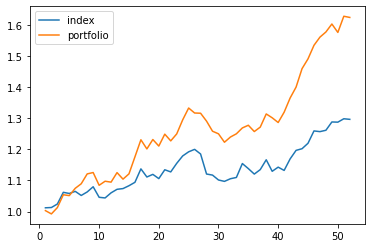

In [299]:
index_and_portfolio_total_return_df = pd.DataFrame(index_and_portfolio_total_return, index = range(1,t_test + 1), columns = ["index","portfolio"])

plt.figure(); index_and_portfolio_total_return_df.plot(); plt.legend(loc='best')
plt.savefig(os.path.join(BASE_DIR,'total_return_result', str(c2)+'_'+ data_name + '.png'))